<a href="https://colab.research.google.com/github/zhanglix/atari_games/blob/master/gym.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install gym gym[atari] pyvirtualdisplay #> /dev/null 2>&1
!apt update
!apt-get install -y xvfb python-opengl ffmpeg #> /dev/null 2>&1

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:6 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease [21.3 kB]
Get:7 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:9 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ Packages [88.1 kB]
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:13 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic InRelease [15.4 kB]
Get:14 http://archive.ubuntu.com/ubuntu bionic-backports InRelea

In [0]:
import gym
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40) #error only

import tensorflow as tf
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import math
import glob
import io
import base64
from IPython.display import HTML

from IPython import display as ipythondisplay
from unittest.mock import MagicMock


In [3]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(200, 200))
display.start()

xdpyinfo was not found, X start can not be checked! Please install xdpyinfo!


<Display cmd_param=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '200x200x24', ':1001'] cmd=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '200x200x24', ':1001'] oserror=None return_code=None stdout="None" stderr="None" timeout_happened=False>

In [0]:
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
  mp4list = sorted(glob.glob('video/*.mp4'))
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    gymlogger.debug('show video: path=%s', mp4)

    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                 controls >
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env, directory='./video', fake_reset=False):
  wenv = Monitor(env, directory, force=True)
  if fake_reset:
        wenv._before_reset()
        wenv._after_reset(None)
  return wenv

def safe_close(wenv):
    mock = MagicMock()
    mock.spec = wenv.env.spec
    wenv.env = mock
    wenv.close()

In [0]:
env = gym.make('Seaquest-v0')
wenv = wrap_env(env)


In [0]:
observation = wenv.reset()


In [0]:
for _ in range(10):
    observation, reward, done, info = wenv.step(env.action_space.sample())
    wenv.render()
    

In [8]:
safe_close(wenv)
show_video()

In [0]:
wenv = wrap_env(env, fake_reset=True)


In [0]:
for _ in range(10):
    observation, reward, done, info = wenv.step(env.action_space.sample())
    wenv.render()

In [11]:
safe_close(wenv)
show_video()

In [12]:
env = gym.make('Seaquest-v0')
observation = env.reset()
print(observation.shape)

(210, 160, 3)


In [0]:
def crop_image(img, start=20, height=160):
    return img[start:start+160]


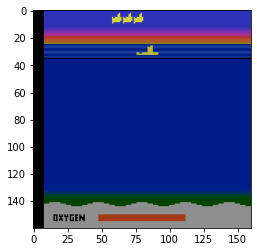

In [14]:
plt.imshow(crop_image(observation))

In [15]:
action_size = env.action_space.n
print(action_size)

18


In [0]:
def add_lstm_layer(input, units, initial_states, final_states):
    initial_memory_state = tf.keras.Input(shape=[units])
    initial_carry_state = tf.keras.Input(shape=[units])
    initial_state = [initial_memory_state, initial_carry_state]
    lstm = tf.keras.layers.LSTM(units, stateful=False, return_state=True, return_sequences=True)
    output, final_memory_state, final_carry_state = lstm(input, initial_state=initial_state)
    final_state =  [final_memory_state, final_carry_state]
    initial_states.append(initial_state)
    final_states.append(final_state)
    return output

def get_base_model(inputs):
    initail_states = []
    final_states = []
    x = tf.keras.layers.Conv2D(8, 3, strides=(2, 2), activation='relu')(inputs)
    x = tf.keras.layers.Conv2D(16, 3, strides=(2, 2), activation='relu')(x)
    x = tf.keras.layers.Conv2D(16, 3, strides=(2, 2), activation='relu')(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, 0),name='to_sequence')(x)
    x = add_lstm_layer(x, 128, initail_states, final_states)
    x = add_lstm_layer(x, 128, initail_states, final_states)
    x = tf.keras.layers.Lambda(lambda x: tf.squeeze(x, axis=0),name='to_batch')(x)
    feature = tf.keras.layers.Dense(64, activation='relu', name="base_feature")(x)
#     return tf.keras.Model( inputs = [inputs, is1[0], is1[1], is2[0], is2[1]],
#                              outputs = [feature, fs1[0], fs1[1], fs2[0], fs2[1]])
    return tf.keras.Model(inputs =[inputs, initail_states], outputs=[feature, final_states])
        
    

In [0]:
def get_action_model(action_size):
    screen = tf.keras.Input(shape=(160,160,3), name="screen")
    base_model = get_base_model(screen)
    logits = tf.keras.layers.Dense(action_size, name="logits")(base_model.output[0])
    action = tf.keras.layers.Lambda(lambda x: tf.random.categorical(x, 1), name='action')(logits)
    return tf.keras.Model(inputs = base_model.input, outputs=[action, base_model.output[1]], name="action")


In [0]:
def get_a3c_model(action_size):
    action_model = get_action_model(action_size)
    feature = action_model.get_layer(name="base_feature").output
    score = tf.keras.layers.Dense(1, name="state_score")(feature)
    outputs = [action_model.output[0], score, action_model.output[1]]
    return tf.keras.Model(inputs = action_model.input, outputs=outputs)

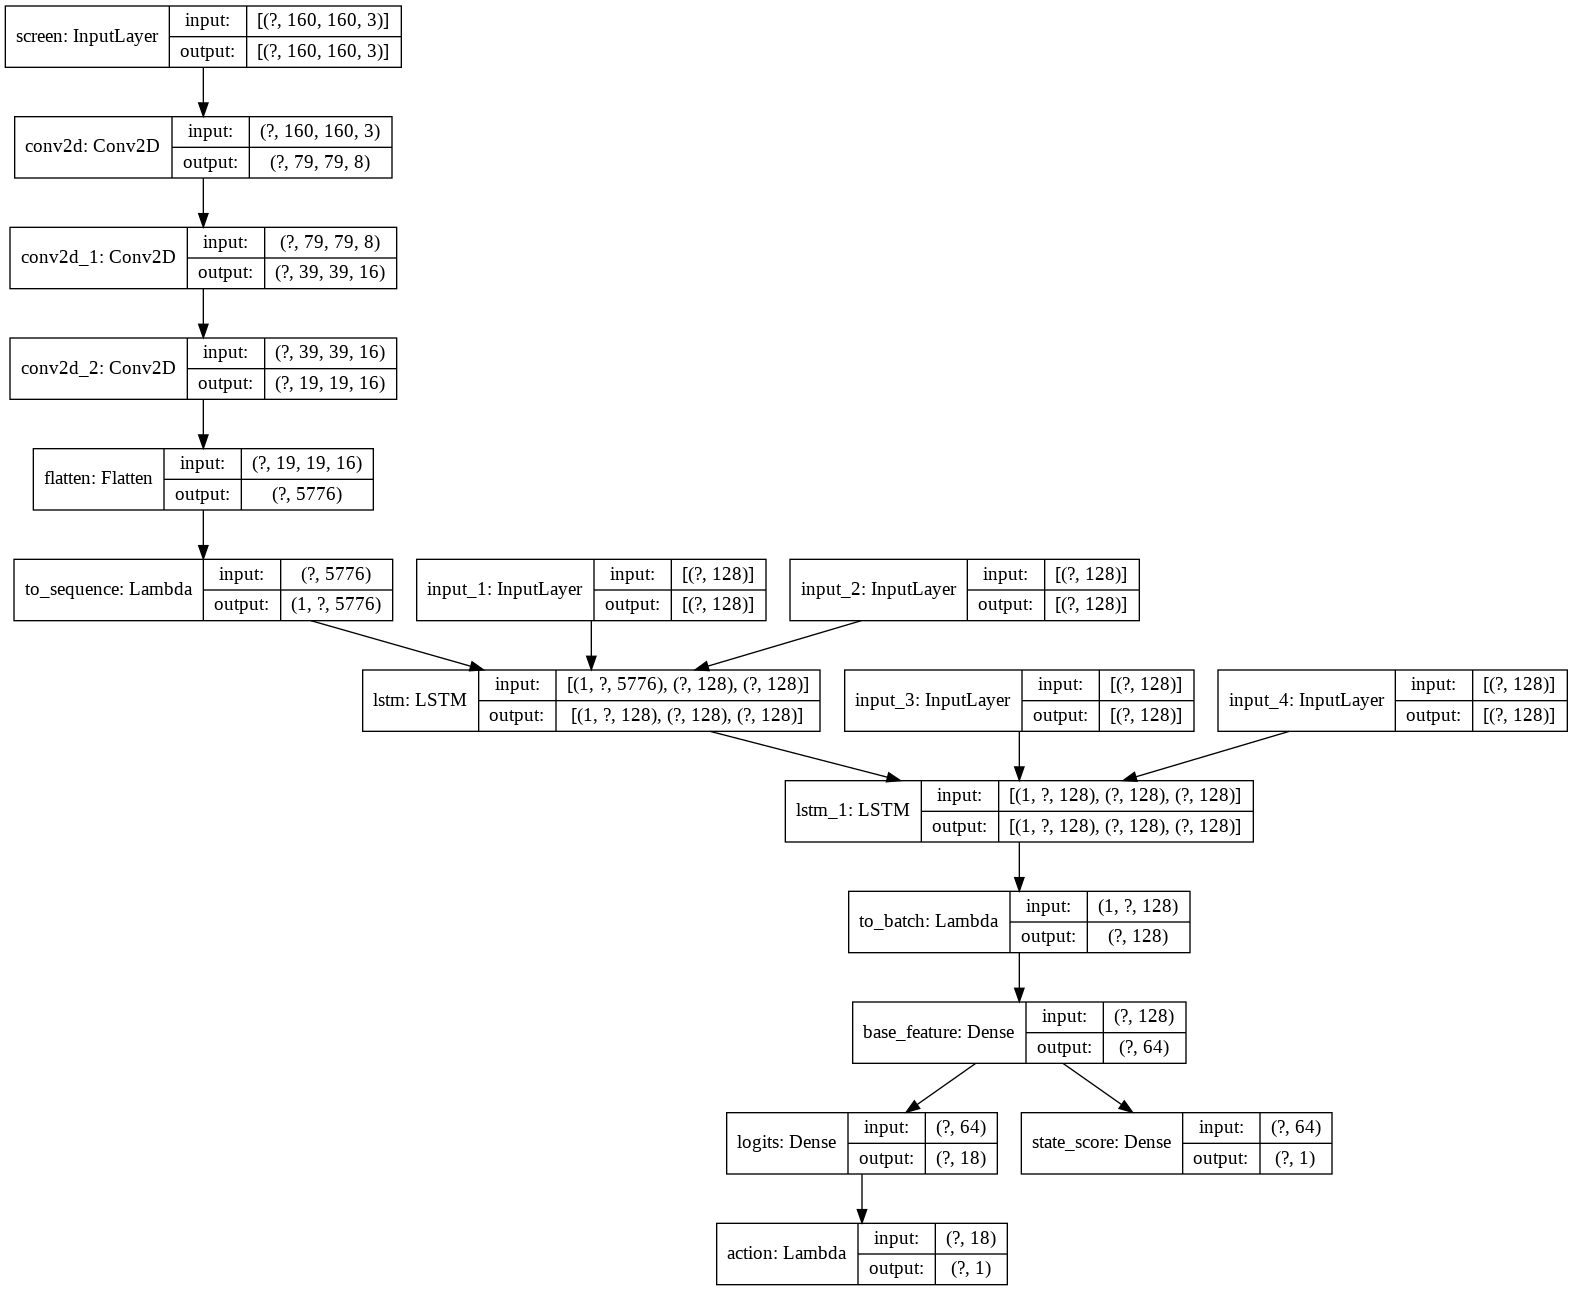

In [19]:
model = get_a3c_model(action_size)
tf.keras.utils.plot_model(model, show_shapes=True)

In [0]:
def get_zero_state(state, batch_size = 1):
    if type(state) == list:
        return [get_zero_state(x) for x in state]
    if type(state) == tf.Tensor:
        shape = state.shape.as_list()
        shape[0] = batch_size
        return tf.zeros(shape, dtype=state.dtype)
    raise ValueError("state is not a valid type")
    


In [0]:
def observation_to_screen(observation, start_row):
    return crop_image(observation, start=start_row)/np.float32(255)
    
def play(model, env, initial_state = None, max_step=6000, render=False, record=False, start_row=20):
    screens = []
    actions = []
    rewards = []

    if initial_state != None:
        gymlogger.debug("resumming play")
        score, done, observation, model_state = initial_state
    else:
        gymlogger.debug("new play")
        score = 0
        done = False
        observation = env.reset()
        model_state = get_zero_state(model.input[1])
        
    for t in range(max_step):
        if render:
            env.render()            
        screen = observation_to_screen(observation, start_row)
        screen = np.stack([screen])
        action, score, model_state = model([[screen], model_state])
        action = action[0].numpy()
        observation, reward, done, info = env.step(action)     
        score += reward       
        if record:
            screens.append(screen)
            actions.append(action)
            rewards.append(reward)
        if done:
            break
    print("Episode finished with score: {} after {} timesteps".format(score[0], t+1))
    return [score, done, observation, model_state], [screens, actions, rewards]

In [0]:
def evaluate(model, env, initial_state = None, **kwargs):
    fake_reset = initial_state != None
    gymlogger.debug("fake reset: {}".format(fake_reset))
    env = wrap_env(env, fake_reset= fake_reset)
    state, _ = play(model, env, render=True, record=False, initial_state=initial_state, **kwargs)
    safe_close(env)
    show_video()
    return state

def record_play(model, env, **kwargs)    :
    return play(model, env, render=False, record=True, **kwargs)

In [0]:
env = gym.make('Seaquest-v0')


In [24]:
state = evaluate(model, env, max_step=10)

Episode finished with score: [0.04259423] after 10 timesteps


In [25]:
state = evaluate(model, env, initial_state=state, max_step=10)

Episode finished with score: [0.05317098] after 10 timesteps


In [26]:
state = evaluate(model, env, initial_state=state, max_step=10)

Episode finished with score: [0.05536241] after 10 timesteps


In [27]:
def estimate_score(rewards, last=0, future_discount=0.99):
    scores = []
    for r in reversed(rewards):
        last = last + r
        scores.append(last)
        last *= future_discount
    return [_ for _ in reversed(scores)]
l = [1 ,2 ,3]
estimate_score(l)

[5.9203, 4.97, 3]